In [1]:
import torch
import torch.nn as nn

# Задача 1

Запустите у себя код из лекции в пункте "Реализация примера сети U-Net вручную"

Увеличьте глубину UNet с дополнительными слоями. Для этого:

1. Добавьте еще один down/up блок (вместо 5 уровней сделайте 6)

2. Убедитесь, что размеры тензоров правильно согласованы

Посмотрите как это отразиться на результате

In [ ]:

import os
if not os.path.exists('data/dataset1'):
    !wget https://github.com/alexgkendall/SegNet-Tutorial/archive/refs/heads/master.zip -O camvid.zip
    !unzip -q camvid.zip
    !rm camvid.zip

--2025-04-11 17:35:39--  https://github.com/alexgkendall/SegNet-Tutorial/archive/refs/heads/master.zip
Распознаётся github.com (github.com)… 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/refs/heads/master [переход]
--2025-04-11 17:35:40--  https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/refs/heads/master
Распознаётся codeload.github.com (codeload.github.com)… 140.82.121.10
Подключение к codeload.github.com (codeload.github.com)|140.82.121.10|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [application/zip]
Сохранение в: ‘camvid.zip’

camvid.zip              [               <=>  ] 178,41M  9,94MB/s    за 96s     

2025-04-11 17:37:17 (1,85 MB/s) - ‘camvid.zip’ сохранён [187075221]



In [7]:
%pip install -q torch_snippets==0.5

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install fastcore==1.5.29

  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.8.1
    Uninstalling fastcore-1.8.1:
      Successfully uninstalled fastcore-1.8.1


In [4]:
import torch
from torch_snippets import *
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
from torch import optim
from torch_snippets.torch_loader import Report

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [ ]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'SegNet-Tutorial-master/CamVid/{split}') 
        self.split = split 

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'SegNet-Tutorial-master/CamVid/{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'SegNet-Tutorial-master/CamVid/{self.split}annot/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224), interpolation=cv2.INTER_NEAREST) 
        return image, mask

    def choose(self): return self[randint(len(self))]
  
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch)) 
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device) 
        return ims, ce_masks

In [ ]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features 
        self.block1 = nn.Sequential(*self.encoder[:6]) 
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512) 
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256) 
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1) 
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


def dice_score(preds, targets):
    preds = torch.softmax(preds, dim=1)
    intersect = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return 2 * intersect / union


def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/home/danya/anaconda3/envs/codetr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/danya/anaconda3/envs/codetr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/danya/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:48<00:00, 11.3MB/s] 


In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 1.142  val_loss: 0.871  trn_acc: 0.753  val_acc: 0.781  (6.15s - 116.79s remaining)
EPOCH: 2.000  trn_loss: 0.622  val_loss: 0.671  trn_acc: 0.840  val_acc: 0.817  (12.04s - 108.34s remaining)
EPOCH: 3.000  trn_loss: 0.519  val_loss: 0.639  trn_acc: 0.856  val_acc: 0.821  (17.93s - 101.58s remaining)
EPOCH: 4.000  trn_loss: 0.443  val_loss: 0.569  trn_acc: 0.875  val_acc: 0.830  (23.81s - 95.25s remaining)
EPOCH: 5.000  trn_loss: 0.406  val_loss: 0.543  trn_acc: 0.881  val_acc: 0.836  (29.70s - 89.10s remaining)
EPOCH: 6.000  trn_loss: 0.378  val_loss: 0.593  trn_acc: 0.886  val_acc: 0.824  (35.59s - 83.05s remaining)
EPOCH: 7.000  trn_loss: 0.344  val_loss: 0.504  trn_acc: 0.894  val_acc: 0.847  (41.47s - 77.01s remaining)
EPOCH: 8.000  trn_loss: 0.302  val_loss: 0.571  trn_acc: 0.905  val_acc: 0.840  (47.35s - 71.03s remaining)
EPOCH: 9.000  trn_loss: 0.289  val_loss: 0.597  trn_acc: 0.909  val_acc: 0.812  (53.26s - 65.09s remaining)
EPOCH: 10.000  trn_loss: 0

100%|██████████| 121/121 [00:00<00:00, 928.04it/s]


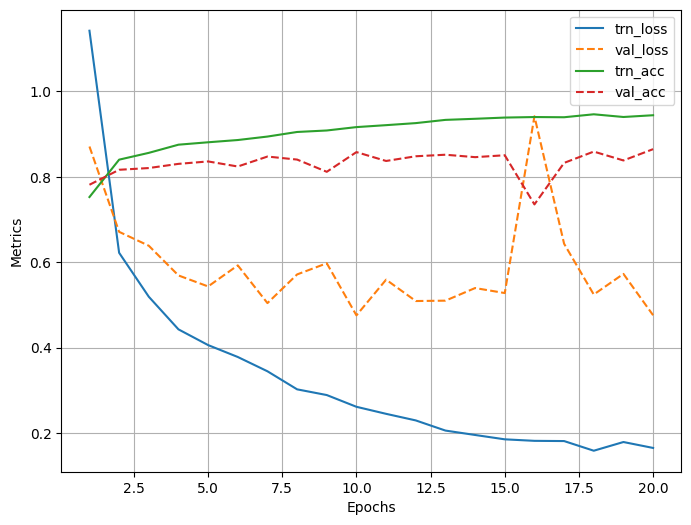

In [18]:
log.plot_epochs(['trn_loss','val_loss', 'trn_acc', 'val_acc'])

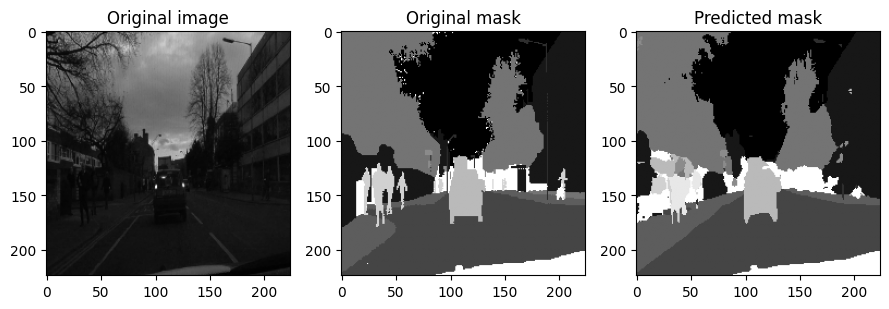

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)


plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original mask')

plt.subplot(1, 3, 3)
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Predicted mask')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

from torchvision.models import vgg16_bn

import torch
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        

        self.block6 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv(512, 1024)
        )
        
        self.conv_bottleneck = conv(1024, 2048)
        

        self.up_conv6 = up_conv(2048, 1024)
        self.conv6    = conv(1024 + 512, 1024)  
        
        self.up_conv7 = up_conv(1024, 512)
        self.conv7    = conv(512 + 512, 512)
        
        self.up_conv8 = up_conv(512, 256)
        self.conv8    = conv(256 + 256, 256)
        
        self.up_conv9 = up_conv(256, 128)
        self.conv9    = conv(128 + 128, 128)
        
        self.up_conv10 = up_conv(128, 64)
        self.conv10    = conv(64 + 64, 64)
        
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)

        x = self.conv_bottleneck(block6)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)
        return x

In [24]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [25]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 0.880  val_loss: 0.870  trn_acc: 0.772  val_acc: 0.740  (7.63s - 144.96s remaining)
EPOCH: 2.000  trn_loss: 0.536  val_loss: 0.880  trn_acc: 0.847  val_acc: 0.747  (15.23s - 137.05s remaining)
EPOCH: 3.000  trn_loss: 0.471  val_loss: 0.543  trn_acc: 0.859  val_acc: 0.839  (22.84s - 129.42s remaining)
EPOCH: 4.000  trn_loss: 0.422  val_loss: 0.584  trn_acc: 0.870  val_acc: 0.823  (30.48s - 121.92s remaining)
EPOCH: 5.000  trn_loss: 0.375  val_loss: 0.542  trn_acc: 0.882  val_acc: 0.835  (38.09s - 114.28s remaining)
EPOCH: 6.000  trn_loss: 0.332  val_loss: 0.488  trn_acc: 0.895  val_acc: 0.843  (45.72s - 106.68s remaining)
EPOCH: 7.000  trn_loss: 0.325  val_loss: 0.568  trn_acc: 0.896  val_acc: 0.815  (53.37s - 99.11s remaining)
EPOCH: 8.000  trn_loss: 0.284  val_loss: 0.671  trn_acc: 0.909  val_acc: 0.797  (60.99s - 91.49s remaining)
EPOCH: 9.000  trn_loss: 0.261  val_loss: 0.478  trn_acc: 0.916  val_acc: 0.851  (68.63s - 83.89s remaining)
EPOCH: 10.000  trn_loss

100%|██████████| 121/121 [00:00<00:00, 1111.64it/s]


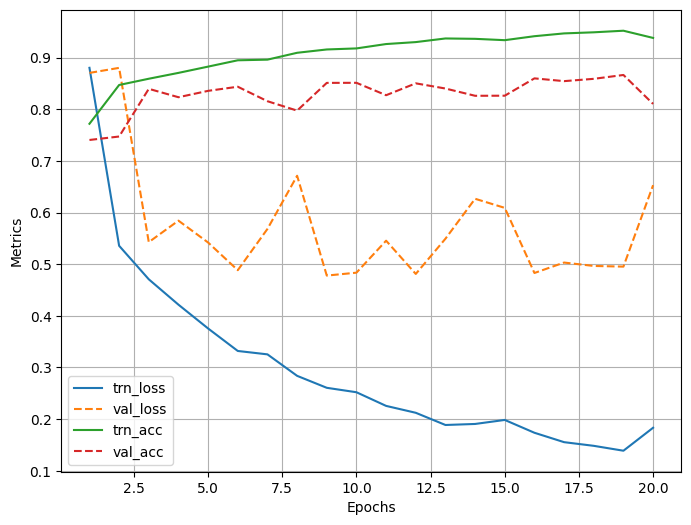

In [26]:
log.plot_epochs(['trn_loss','val_loss', 'trn_acc', 'val_acc'])

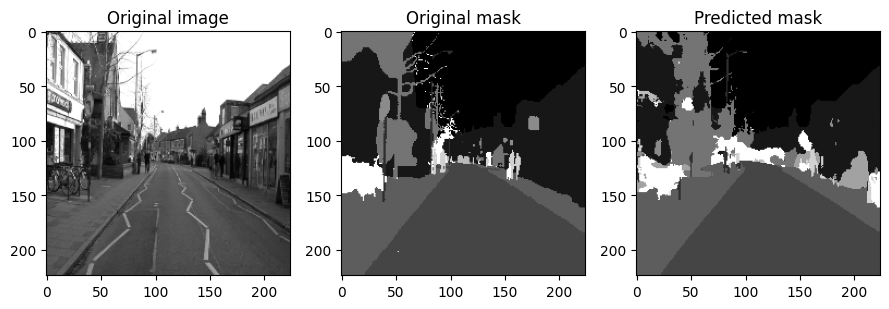

In [27]:
im, mask = next(iter(val_dl))
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original mask')

plt.subplot(1, 3, 3)
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Predicted mask')

plt.tight_layout()
plt.show()

# Задача 2

Пользуясь примером из лекции для сети U-Net на основе VGG16_bn, задайте архитектуру на основе ResNet, проведите обучение на том же датасете.

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNetResNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        base_model = resnet18(pretrained=pretrained)
        
        self.encoder0 = nn.Sequential(
            base_model.conv1, 
            base_model.bn1,
            base_model.relu
        )  
        
        self.maxpool = base_model.maxpool  
        
        self.encoder1 = base_model.layer1   
        self.encoder2 = base_model.layer2   
        self.encoder3 = base_model.layer3   
        self.encoder4 = base_model.layer4   
        
        
        self.bottleneck = conv_block(512, 1024)        
        
        
        self.up4 = up_conv(1024, 512)
        
        self.dec4 = conv_block(512 + 256, 512)
        
        self.up3 = up_conv(512, 256)
        
        self.dec3 = conv_block(256 + 128, 256)
        
        self.up2 = up_conv(256, 128)

        self.dec2 = conv_block(128 + 64, 128)
        
        self.up1 = up_conv(128, 64)
        
        self.dec1 = conv_block(64 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc0 = self.encoder0(x)         
        pool0 = self.maxpool(enc0)        
        enc1 = self.encoder1(pool0)       
        enc2 = self.encoder2(enc1)        
        enc3 = self.encoder3(enc2)        
        enc4 = self.encoder4(enc3)        
        
        bn = self.bottleneck(enc4)        
        
        
        dec4 = self.up4(bn)               
        dec4 = torch.cat([dec4, enc3], dim=1)  
        dec4 = self.dec4(dec4)            
        
        dec3 = self.up3(dec4)             
        dec3 = torch.cat([dec3, enc2], dim=1)  
        dec3 = self.dec3(dec3)            
        
        dec2 = self.up2(dec3)             
        dec2 = torch.cat([dec2, enc1], dim=1)  
        dec2 = self.dec2(dec2)            
        
        dec1 = self.up1(dec2)             
        dec1 = torch.cat([dec1, enc0], dim=1)  
        dec1 = self.dec1(dec1)            
        
        out = F.interpolate(dec1, scale_factor=2, mode='bilinear', align_corners=True)  
        out = self.conv_last(out)         
        return out

In [60]:
model = UNetResNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/home/danya/anaconda3/envs/codetr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 0.900  val_loss: 0.767  trn_acc: 0.773  val_acc: 0.780  (3.97s - 75.39s remaining)
EPOCH: 2.000  trn_loss: 0.568  val_loss: 0.704  trn_acc: 0.839  val_acc: 0.789  (7.87s - 70.86s remaining)
EPOCH: 3.000  trn_loss: 0.476  val_loss: 0.740  trn_acc: 0.860  val_acc: 0.785  (11.77s - 66.69s remaining)
EPOCH: 4.000  trn_loss: 0.426  val_loss: 0.590  trn_acc: 0.870  val_acc: 0.824  (15.66s - 62.64s remaining)
EPOCH: 5.000  trn_loss: 0.376  val_loss: 0.637  trn_acc: 0.884  val_acc: 0.809  (19.55s - 58.65s remaining)
EPOCH: 6.000  trn_loss: 0.354  val_loss: 0.577  trn_acc: 0.888  val_acc: 0.824  (23.45s - 54.73s remaining)
EPOCH: 7.000  trn_loss: 0.304  val_loss: 0.552  trn_acc: 0.903  val_acc: 0.829  (27.35s - 50.79s remaining)
EPOCH: 8.000  trn_loss: 0.301  val_loss: 0.623  trn_acc: 0.904  val_acc: 0.815  (31.24s - 46.86s remaining)
EPOCH: 9.000  trn_loss: 0.284  val_loss: 0.568  trn_acc: 0.908  val_acc: 0.836  (35.11s - 42.92s remaining)
EPOCH: 10.000  trn_loss: 0.248

100%|██████████| 121/121 [00:00<00:00, 912.18it/s]


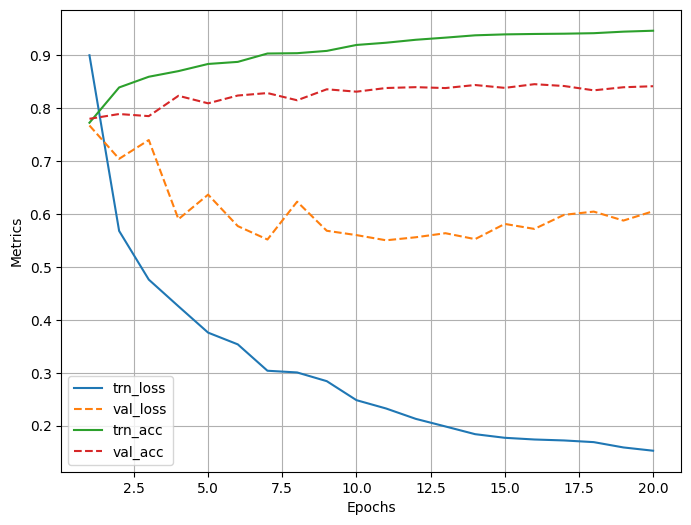

In [64]:
log.plot_epochs(['trn_loss','val_loss', 'trn_acc', 'val_acc'])

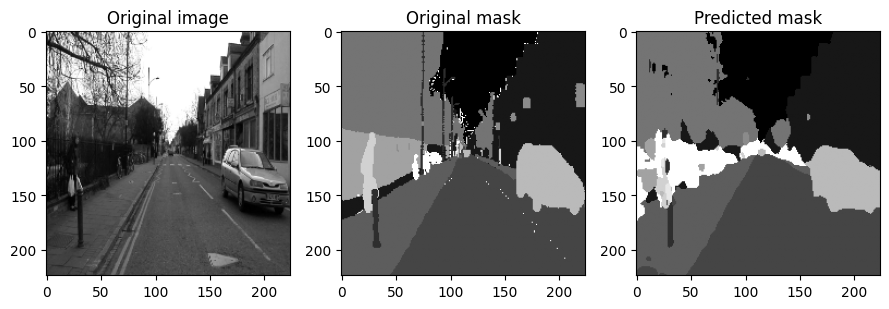

In [75]:
im, mask = next(iter(val_dl))
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Original mask')

plt.subplot(1, 3, 3)
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0].numpy(), cmap='gray')
plt.title('Predicted mask')

plt.tight_layout()
plt.show()